In [1]:
import pandas as pd 
import geopandas as gpd 


In [2]:
input_path = "../data/input/"
output_path = "../data/output/"

### import Main data: 

In [3]:
main_data = pd.read_parquet(input_path + "yellow_tripdata_2024_01.parquet")

In [4]:
main_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [5]:
main_data['PULocationID'].nunique() 

260

In [6]:
main_data['DOLocationID'].nunique()

261

In [7]:
main_data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964624 entries, 0 to 2964623
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

### import the zones detailed data + create the latitude and longitude columns: 

In [8]:

# Read the shapefile
gdf = gpd.read_file(input_path + "zones/taxi_zones.shp")

In [9]:
gdf.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144..."


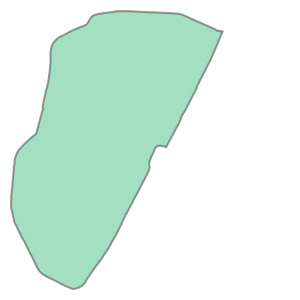

In [10]:
gdf['geometry'][0]

In [11]:
print(gdf.geometry.centroid)


0        POINT (935996.821 191376.75)
1      POINT (1031085.719 164018.754)
2      POINT (1026452.617 254265.479)
3       POINT (990633.981 202959.782)
4        POINT (931871.37 140681.351)
                    ...              
258    POINT (1025106.231 266453.415)
259    POINT (1010211.977 210434.892)
260     POINT (980639.512 197635.174)
261     POINT (999064.725 221974.401)
262      POINT (997817.92 223005.988)
Length: 263, dtype: geometry


In [12]:
# Extract latitude and longitude separately
gdf['latitude'] = gdf.geometry.centroid.y
gdf['longitude'] = gdf.geometry.centroid.x



In [13]:
print(gdf[['zone', 'latitude', 'longitude']])

                        zone       latitude     longitude
0             Newark Airport  191376.749531  9.359968e+05
1                Jamaica Bay  164018.754403  1.031086e+06
2    Allerton/Pelham Gardens  254265.478659  1.026453e+06
3              Alphabet City  202959.782391  9.906340e+05
4              Arden Heights  140681.351376  9.318714e+05
..                       ...            ...           ...
258       Woodlawn/Wakefield  266453.414552  1.025106e+06
259                 Woodside  210434.891894  1.010212e+06
260       World Trade Center  197635.173702  9.806395e+05
261           Yorkville East  221974.400788  9.990647e+05
262           Yorkville West  223005.988409  9.978179e+05

[263 rows x 3 columns]


In [14]:
gdf_join = gdf[['LocationID', 'zone', 'borough', 'latitude', 'longitude']]

### join the zone data wiht the main data: 

In [15]:
# Join with pickup location
main_data = main_data.merge(gdf_join.rename(columns={'LocationID': 'PULocationID', 
                                                       'zone': 'pickup_zone', 
                                                       'borough': 'pickup_borough', 
                                                       'latitude': 'pickup_latitude', 
                                                       'longitude': 'pickup_longitude'}), 
                            on='PULocationID', how='left')

# Join with dropoff location
main_data = main_data.merge(gdf_join.rename(columns={'LocationID': 'DOLocationID', 
                                                       'zone': 'dropoff_zone', 
                                                       'borough': 'dropoff_borough', 
                                                       'latitude': 'dropoff_latitude', 
                                                       'longitude': 'dropoff_longitude'}), 
                            on='DOLocationID', how='left')

In [16]:
# Rename datetime columns
main_data = main_data.rename(columns={
    'tpep_pickup_datetime': 'pickup_datetime',
    'tpep_dropoff_datetime': 'dropoff_datetime'
})

In [17]:
main_data.head()

,VendorID,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,congestion_surcharge,Airport_fee,pickup_zone,pickup_borough,pickup_latitude,pickup_longitude,dropoff_zone,dropoff_borough,dropoff_latitude,dropoff_longitude
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,...,2.5,0.0,Penn Station/Madison Sq West,Manhattan,211974.446219,986345.398600,East Village,Manhattan,204368.501875,988147.657991
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,...,2.5,0.0,Lenox Hill East,Manhattan,218166.434353,996787.663055,Upper East Side North,Manhattan,223613.753576,996155.386766
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,...,2.5,0.0,Upper East Side North,Manhattan,223613.753576,996155.386766,East Village,Manhattan,204368.501875,988147.657991
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,...,2.5,0.0,East Village,Manhattan,204368.501875,988147.657991,SoHo,Manhattan,203008.491333,983823.807116
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,...,2.5,0.0,SoHo,Manhattan,203008.491333,983823.807116,Lower East Side,Manhattan,201205.264892,986773.546092


In [18]:
main_data.columns

Index(['VendorID', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID',
       'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'Airport_fee', 'pickup_zone', 'pickup_borough',
       'pickup_latitude', 'pickup_longitude', 'dropoff_zone',
       'dropoff_borough', 'dropoff_latitude', 'dropoff_longitude'],
      dtype='object')

In [19]:

best_columns = ['pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'trip_distance',
       'payment_type', 'fare_amount', 'total_amount', 
       'pickup_zone', 'pickup_borough', 'pickup_latitude', 'pickup_longitude', 
       'dropoff_zone', 'dropoff_borough', 'dropoff_latitude', 'dropoff_longitude']


In [20]:
''' 
the professor needs:
trip_id, pickup_datetime, pickup_location (longitude, latitude, borough),
dropoff_location, passenger_count, trip_distance, fare_amount.
'''

prof_needs = ['pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'trip_distance', 'fare_amount',
       'pickup_borough', 'pickup_latitude', 'pickup_longitude', 
       'dropoff_borough', 'dropoff_latitude', 'dropoff_longitude']

In [54]:
final_main_data = main_data[best_columns][:500000] 

In [55]:
final_main_data_prof_col = main_data[prof_needs]

In [56]:
final_main_data.isna().sum()

pickup_datetime         0
dropoff_datetime        0
passenger_count         0
trip_distance           0
payment_type            0
fare_amount             0
total_amount            0
pickup_zone          2257
pickup_borough       2257
pickup_latitude      2257
pickup_longitude     2257
dropoff_zone         5454
dropoff_borough      5454
dropoff_latitude     5454
dropoff_longitude    5454
dtype: int64

In [57]:
# fill the missing values with 'Unknown' for categorical columns:
final_main_data['pickup_borough'].fillna('Unknown', inplace=True)
final_main_data['pickup_zone'].fillna('Unknown', inplace=True)
final_main_data['dropoff_borough'].fillna('Unknown', inplace=True)
final_main_data['dropoff_zone'].fillna('Unknown', inplace=True)

final_main_data['pickup_latitude'].fillna(0.0, inplace=True)
final_main_data['pickup_longitude'].fillna(0.0, inplace=True)
final_main_data['dropoff_latitude'].fillna(0.0, inplace=True)
final_main_data['dropoff_longitude'].fillna(0.0, inplace=True)

C:\Users\RAZER\AppData\Local\Temp\ipykernel_28172\687633600.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_main_data['pickup_borough'].fillna('Unknown', inplace=True)
C:\Users\RAZER\AppData\Local\Temp\ipykernel_28172\687633600.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

In [58]:
final_main_data.isna().sum()

pickup_datetime      0
dropoff_datetime     0
passenger_count      0
trip_distance        0
payment_type         0
fare_amount          0
total_amount         0
pickup_zone          0
pickup_borough       0
pickup_latitude      0
pickup_longitude     0
dropoff_zone         0
dropoff_borough      0
dropoff_latitude     0
dropoff_longitude    0
dtype: int64

### save the data as json file

In [59]:
# Add id column
final_main_data.insert(0, 'trip_id', range(1, len(final_main_data) + 1 ))

# Save as JSON
final_main_data.to_json(output_path + 'final_data.json', orient='records', indent=2 , date_format='iso')

print(f"File saved to {output_path}final_data.json")
print(f"Total records: {len(final_main_data)}")
print(final_main_data.head())


File saved to ../data/output/final_data.json
Total records: 500000
   trip_id     pickup_datetime    dropoff_datetime  passenger_count  \
0        1 2024-01-01 00:57:55 2024-01-01 01:17:43              1.0   
1        2 2024-01-01 00:03:00 2024-01-01 00:09:36              1.0   
2        3 2024-01-01 00:17:06 2024-01-01 00:35:01              1.0   
3        4 2024-01-01 00:36:38 2024-01-01 00:44:56              1.0   
4        5 2024-01-01 00:46:51 2024-01-01 00:52:57              1.0   

   trip_distance  payment_type  fare_amount  total_amount  \
0           1.72             2         17.7         22.70   
1           1.80             1         10.0         18.75   
2           4.70             1         23.3         31.30   
3           1.40             1         10.0         17.00   
4           0.80             1          7.9         16.10   

                    pickup_zone pickup_borough  pickup_latitude  \
0  Penn Station/Madison Sq West      Manhattan    211974.446219   
1    

In [60]:
# # Add id column
# final_main_data_prof_col.insert(0, 'trip_id', range(1, len(final_main_data_prof_col) + 1))

# # Save as JSON
# final_main_data_prof_col.to_json(output_path + 'final_data_prof_col.json', orient='records', indent=2 , date_format='iso')

# print(f"File saved to {output_path}final_data_prof_col.json")
# print(f"Total records: {len(final_main_data_prof_col)}")
# print(final_main_data_prof_col.head())

In [61]:
##### just for testing #####

### Show first 100 lines of the JSON file ###
# Read first 100 lines of JSON file
with open(output_path + 'final_data.json', 'r') as f:
    lines = [next(f) for _ in range(100)]
    
for i, line in enumerate(lines, 1):
    print(f"{i}: {line.rstrip()}")

1: [
2:   {
3:     "trip_id":1,
4:     "pickup_datetime":"2024-01-01T00:57:55.000",
5:     "dropoff_datetime":"2024-01-01T01:17:43.000",
6:     "passenger_count":1.0,
7:     "trip_distance":1.72,
8:     "payment_type":2,
9:     "fare_amount":17.7,
10:     "total_amount":22.7,
11:     "pickup_zone":"Penn Station\/Madison Sq West",
12:     "pickup_borough":"Manhattan",
13:     "pickup_latitude":211974.4462185665,
14:     "pickup_longitude":986345.3986004688,
15:     "dropoff_zone":"East Village",
16:     "dropoff_borough":"Manhattan",
17:     "dropoff_latitude":204368.5018753222,
18:     "dropoff_longitude":988147.6579909977
19:   },
20:   {
21:     "trip_id":2,
22:     "pickup_datetime":"2024-01-01T00:03:00.000",
23:     "dropoff_datetime":"2024-01-01T00:09:36.000",
24:     "passenger_count":1.0,
25:     "trip_distance":1.8,
26:     "payment_type":1,
27:     "fare_amount":10.0,
28:     "total_amount":18.75,
29:     "pickup_zone":"Lenox Hill East",
30:     "pickup_borough":"Manhattan",
3

In [62]:
final_main_data.columns

Index(['trip_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_distance', 'payment_type', 'fare_amount', 'total_amount',
       'pickup_zone', 'pickup_borough', 'pickup_latitude', 'pickup_longitude',
       'dropoff_zone', 'dropoff_borough', 'dropoff_latitude',
       'dropoff_longitude'],
      dtype='object')

In [63]:
final_main_data.isna().sum()

trip_id              0
pickup_datetime      0
dropoff_datetime     0
passenger_count      0
trip_distance        0
payment_type         0
fare_amount          0
total_amount         0
pickup_zone          0
pickup_borough       0
pickup_latitude      0
pickup_longitude     0
dropoff_zone         0
dropoff_borough      0
dropoff_latitude     0
dropoff_longitude    0
dtype: int64

In [64]:
final_main_data['pickup_borough'].unique()

array(['Manhattan', 'Queens', 'Brooklyn', 'Unknown', 'Bronx',
       'Staten Island', 'EWR'], dtype=object)

In [65]:
final_main_data.value_counts()

trip_id  pickup_datetime      dropoff_datetime     passenger_count  trip_distance  payment_type  fare_amount  total_amount  pickup_zone                   pickup_borough  pickup_latitude  pickup_longitude  dropoff_zone                  dropoff_borough  dropoff_latitude  dropoff_longitude
499984   2024-01-06 20:06:20  2024-01-06 20:20:25  1.0              2.81           1             16.3         25.56         Clinton East                  Manhattan       216986.070034    987063.185702     Yorkville West                Manhattan        223005.988409     997817.919661        1
499983   2024-01-06 20:52:34  2024-01-06 20:58:39  2.0              0.82           1             7.2          14.64         Union Sq                      Manhattan       209001.626630    986894.236796     Penn Station/Madison Sq West  Manhattan        211974.446219     986345.398600        1
499982   2024-01-06 20:54:02  2024-01-06 20:59:06  1.0              0.87           1             7.2          14.64         Tr

In [66]:
len(main_data[best_columns]) - main_data[best_columns]['pickup_borough'].value_counts().sum()


np.int64(12030)

In [67]:
main_data[best_columns]['pickup_borough'].value_counts()

pickup_borough
Manhattan        2647174
Queens            274014
Brooklyn           25289
Bronx               6921
EWR                  295
Staten Island         72
Name: count, dtype: int64

In [68]:
len(final_main_data)

500000